# 4. CLASSIFICATION PREDICTION

NOTE: This notebook follows from the notebook on Data Preprocessing and Exploratory Analysis.

This notebook contains all of the classification prediction procedures we ran to try and respond to research question two as outlined in the notebook on cleaning and exploratory analysis. The research question of note here is:

*Can we build a classifier that can effectively predict which party a politician belongs to by using what they said and a few demographic qualities?*



## 4.1 Data preparation for prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # just to flush out some depreciation warnings and the likes

In [3]:
#Here we reimport the cleaned data to avoid having to rerun the cleaning every time
df=pd.read_csv('cleaned_nonans.csv')

In [4]:
clean_names = []
for i in df['Speaker_party_name'].tolist():
    if (i == 'Forza Italia Berlusconi Presidente-UDC') | (i == 'Forza Italia-Berlusconi Presidente') | (i == 'Forza Italia-Il Popolo della Libertà XVII Legislatura'):
        clean_names.append('Forza Italia')
    elif (i == 'Lega-Salvini Premier') | (i == "Lega-Salvini Premier-Partito Sardo d'Azione"):
        clean_names.append('Lega')
    elif i == 'MoVimento 5 Stelle':
        clean_names.append('Movimento 5 Stelle')
    else:
        clean_names.append(i)
df['Party_name_red'] = clean_names

In [5]:
df=df[(df['Party_name_red']!='Per le Autonomie (SVP-PATT, UV)') & (df['Party_name_red']!='Italia Viva - P.S.I.')]

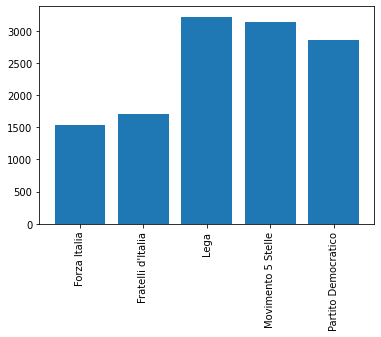

In [6]:
#Plotting party distributions
arr = np.array(df['Party_name_red'])
labels, counts = np.unique(arr, return_counts = True)
plt.bar(labels, counts, align = 'center')
plt.xticks(rotation = 90)
plt.show()

Like we have explained in the previous notebook (Exploratory analysis) we will utilise the same five party classes and thus have a five-way classification task. Like before the classes to predict are:
1. Forza Italia (Centre-Right wing)
2. Fratelli d'Italia (Centre-Right wing)
3. Lega (Centre-Right wing)
4. Movimento 5 Stelle (Centre-Left wing)
5. Partitio Democratico (Centre-Left wing)

In [7]:
from scipy import sparse
coalition=pd.get_dummies(df['Party_status'], prefix=None)[['Coalition']]
df['coalition_bin']=coalition
regular=pd.get_dummies(df['Speaker_role'], prefix=None)[['Regular']]
df['regular_bin']=regular
female=pd.get_dummies(df['Speaker_gender'], prefix=None)[['F']]
df['female']=female

In [8]:
np.random.seed(4)
data = df.sample(frac=1, random_state=4)

N = len(df)
train_size = int(N*0.6)
dev_size = int(N*0.2)
test_size = int(N*0.2)

train = data[:train_size]
dev = data[train_size: train_size+dev_size]
test = data[train_size+dev_size:]
print(len(train), len(dev), len(test))

target='Party_name_red'
y_train = train[target]
y_dev = dev[target]
y_test = test[target]

7472 2490 2492


In [10]:
#Label distribution in the train set
from collections import Counter
{k: v/len(y_train) for k, v in Counter(y_train).items()}


{'Forza Italia': 0.12232334047109207,
 'Lega': 0.25963597430406854,
 'Movimento 5 Stelle': 0.2494646680942184,
 'Partito Democratico': 0.22885438972162742,
 "Fratelli d'Italia": 0.13972162740899358}

In [11]:
#Label distribution in the dev set
{k: v/len(y_dev) for k, v in Counter(y_dev).items()}

{'Lega': 0.24859437751004015,
 'Movimento 5 Stelle': 0.26104417670682734,
 'Forza Italia': 0.12329317269076305,
 "Fratelli d'Italia": 0.13453815261044177,
 'Partito Democratico': 0.2325301204819277}

In [12]:
#Label distribution in the test set
{k: v/len(y_test) for k, v in Counter(y_test).items()}

{'Movimento 5 Stelle': 0.24879614767255218,
 "Fratelli d'Italia": 0.13443017656500802,
 'Partito Democratico': 0.22792937399678972,
 'Forza Italia': 0.12439807383627609,
 'Lega': 0.264446227929374}

The distribution of the political parties between train, dev and test appears to be even.

## 4.2 Baselines

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(ngram_range=(2,6), 
                             analyzer='char')

In [14]:
from scipy import sparse
#Adding other covariates to teh design matrix
X_train_hulk = vectorizer.fit_transform(train['lemmatized'])
coalition_bin=np.array(train['coalition_bin'].tolist()).reshape(X_train_hulk.shape[0],1)
regular_bin=np.array(train['regular_bin'].tolist()).reshape(X_train_hulk.shape[0],1)
female=np.array(train['female'].tolist()).reshape(X_train_hulk.shape[0],1)
age = np.array(train['Speaker_birth'].tolist()).reshape(X_train_hulk.shape[0],1)
year = np.array(train['Year'].tolist()).reshape(X_train_hulk.shape[0],1)
X_train_hulk=sparse.csr_matrix(np.hstack((X_train_hulk.todense(), coalition_bin, regular_bin, female, age, year)))

X_dev_hulk = vectorizer.transform(dev['lemmatized'])
coalition_bin=np.array(dev['coalition_bin'].tolist()).reshape(X_dev_hulk.shape[0],1)
regular_bin=np.array(dev['regular_bin'].tolist()).reshape(X_dev_hulk.shape[0],1)
female=np.array(dev['female'].tolist()).reshape(X_dev_hulk.shape[0],1)
age = np.array(dev['Speaker_birth'].tolist()).reshape(X_dev_hulk.shape[0],1)
year = np.array(dev['Year'].tolist()).reshape(X_dev_hulk.shape[0],1)
X_dev_hulk=sparse.csr_matrix(np.hstack((X_dev_hulk.todense(), coalition_bin, regular_bin, female, age, year)))


X_test_hulk = vectorizer.transform(test['lemmatized'])
coalition_bin=np.array(test['coalition_bin'].tolist()).reshape(X_test_hulk.shape[0],1)
regular_bin=np.array(test['regular_bin'].tolist()).reshape(X_test_hulk.shape[0],1)
female=np.array(test['female'].tolist()).reshape(X_test_hulk.shape[0],1)
age = np.array(test['Speaker_birth'].tolist()).reshape(X_test_hulk.shape[0],1)
year = np.array(test['Year'].tolist()).reshape(X_test_hulk.shape[0],1)
X_test_hulk=sparse.csr_matrix(np.hstack((X_test_hulk.todense(), coalition_bin, regular_bin, female, age, year)))

In [15]:
X_train_hulk.shape, X_dev_hulk.shape, X_test_hulk.shape

((7472, 330876), (2490, 330876), (2492, 330876))

### Dummy classifier

In [20]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train_hulk, y_train)

dumb_predictions = most_frequent.predict(X_dev_hulk)

print(classification_report(y_dev, dumb_predictions))
print(f1_score(y_dev, dumb_predictions, average='micro'))

                     precision    recall  f1-score   support

       Forza Italia       0.00      0.00      0.00       307
  Fratelli d'Italia       0.00      0.00      0.00       335
               Lega       0.25      1.00      0.40       619
 Movimento 5 Stelle       0.00      0.00      0.00       650
Partito Democratico       0.00      0.00      0.00       579

           accuracy                           0.25      2490
          macro avg       0.05      0.20      0.08      2490
       weighted avg       0.06      0.25      0.10      2490

0.24859437751004015


### Logistic regression baseline (Hulk)

In [21]:
#The baseline classifier with characters
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

classifier_hulk = LogisticRegression(max_iter=2000, random_state = 4)
classifier_hulk.fit(X_train_hulk, y_train)
predictions_hulk = classifier_hulk.predict(X_dev_hulk)
print(classification_report(y_dev, predictions_hulk))
print(f1_score(y_dev, predictions_hulk, average='micro'))

                     precision    recall  f1-score   support

       Forza Italia       0.68      0.57      0.62       307
  Fratelli d'Italia       0.56      0.72      0.63       335
               Lega       0.54      0.60      0.57       619
 Movimento 5 Stelle       0.66      0.90      0.76       650
Partito Democratico       0.70      0.27      0.39       579

           accuracy                           0.61      2490
          macro avg       0.63      0.61      0.59      2490
       weighted avg       0.63      0.61      0.59      2490

0.6132530120481928


## 4.3 Classification algorithms

### Testing Embeddings
We first decided to test the effects that different embeddings could have on performance. For computational efficiency reasons (instead of testing all the different combinations of algorithms/embeddings that we will present in the following section), we decided to test the effect of the different embeddings on the accuracy of a Logistic regression with base values for all parameters. This could give us a practical 'embedding baseline to decide what to use for the rest of the classification task.

#### TF-IDF with word analyzer
First we test a TFIDF encoding utilising a 'word' analyser and some regularization on min and max term frequency

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(ngram_range=(2,6),min_df=0.001, 
                             max_df=0.7, 
                             analyzer='word',
                             sublinear_tf=True)

In [14]:
X_train = vectorizer.fit_transform(train['lemmatized'])
coalition_bin=np.array(train['coalition_bin'].tolist()).reshape(X_train.shape[0],1)
regular_bin=np.array(train['regular_bin'].tolist()).reshape(X_train.shape[0],1)
female=np.array(train['female'].tolist()).reshape(X_train.shape[0],1)
age = np.array(train['Speaker_birth'].tolist()).reshape(X_train.shape[0],1)
year = np.array(train['Year'].tolist()).reshape(X_train.shape[0],1)
X_train=np.hstack((X_train.todense(), coalition_bin, regular_bin, female, age, year))
X_train= sparse.csr_matrix(X_train)

X_dev = vectorizer.transform(dev['lemmatized'])
coalition_bin=np.array(dev['coalition_bin'].tolist()).reshape(X_dev.shape[0],1)
regular_bin=np.array(dev['regular_bin'].tolist()).reshape(X_dev.shape[0],1)
female=np.array(dev['female'].tolist()).reshape(X_dev.shape[0],1)
age = np.array(dev['Speaker_birth'].tolist()).reshape(X_dev.shape[0],1)
year = np.array(dev['Year'].tolist()).reshape(X_dev.shape[0],1)
X_dev=np.hstack((X_dev.todense(), coalition_bin, regular_bin, female, age, year))
X_dev= sparse.csr_matrix(X_dev)


X_test = vectorizer.transform(test['lemmatized'])
coalition_bin=np.array(test['coalition_bin'].tolist()).reshape(X_test.shape[0],1)
regular_bin=np.array(test['regular_bin'].tolist()).reshape(X_test.shape[0],1)
female=np.array(test['female'].tolist()).reshape(X_test.shape[0],1)
age = np.array(test['Speaker_birth'].tolist()).reshape(X_test.shape[0],1)
year = np.array(test['Year'].tolist()).reshape(X_test.shape[0],1)
X_test=np.hstack((X_test.todense(), coalition_bin, regular_bin, female, age, year))
X_test= sparse.csr_matrix(X_test)

In [15]:
X_train.shape, X_dev.shape, X_test.shape

((7472, 11542), (2490, 11542), (2492, 11542))

In [25]:
#The baseline classifier TFIDF
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

classifier_embedding_bs = LogisticRegression(max_iter=2000, random_state = 4)
classifier_embedding_bs.fit(X_train, y_train)
predictions = classifier_embedding_bs.predict(X_dev)
print(classification_report(y_dev, predictions))
print(f1_score(y_dev, predictions, average='micro'))

                     precision    recall  f1-score   support

       Forza Italia       0.70      0.56      0.62       307
  Fratelli d'Italia       0.62      0.73      0.67       335
               Lega       0.80      0.55      0.65       619
 Movimento 5 Stelle       0.64      0.92      0.76       650
Partito Democratico       0.51      0.43      0.47       579

           accuracy                           0.65      2490
          macro avg       0.65      0.64      0.63      2490
       weighted avg       0.65      0.65      0.64      2490

0.6453815261044177


#### Doc2Vec embeddings
To be consistent and utiise the same embeddings we tuned in the exploratory analyses, we set the same random seed as in the previosu Doc2Vec run

In [13]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
np.random.seed(4)
#Adding unique entry for each document for subsequent Doc2Vec Embedding
df['id'] = range(df.shape[0])

# create a list of TaggedDocument objects
corpus = []

for row in df.iterrows(): 
    label = row[1].id
    text = row[1].lemmatized
    corpus.append(TaggedDocument(words=text.split(), 
                                 tags=[str(label)]))

print('done')
# initialize model
d2v_model = Doc2Vec(vector_size=300, 
                    window=15,
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1)

# build the vocabulary
d2v_model.build_vocab(corpus)

# train the model
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

done


In [23]:
docembs = d2v_model.dv.vectors
docembsdf = pd.DataFrame(docembs)
docembsdf
dfdoc = pd.concat([df, docembsdf], axis = 1)
dfdoc.shape

(13121, 318)

In [24]:
#Splitting the data

data2 = dfdoc.sample(frac=1, random_state = 4) #using same random seed as before

# determine the size of training, develpment and test set:
N = len(data)
train_size = int(N*0.6)
dev_size = int(N*0.2)
test_size = int(N*0.2)

# split the data into training, develpment and test set:
train2 = data[:train_size]
dev2 = data[train_size: train_size+dev_size]
test2 = data[train_size+dev_size:]

y_train = train['Party_name_red']
y_dev = dev['Party_name_red']
y_test = test['Party_name_red']

In [25]:
x_tr_doc = train2.loc[:, 'coalition_bin':]
x_tr_doc = pd.concat([x_tr_doc, train[['Year','Speaker_birth']]], axis = 1)
x_dev_doc = dev2.loc[:, 'coalition_bin':]
x_dev_doc = pd.concat([x_dev_doc, dev[['Year','Speaker_birth']]], axis = 1)
x_te_doc = test2.loc[:, 'coalition_bin':]
x_te_doc = pd.concat([x_te_doc, test[['Year','Speaker_birth']]], axis = 1)

In [26]:
#The baseline classifier Doc2Vec
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

classifier_embedding_bs = LogisticRegression(max_iter=2000, random_state = 4)
classifier_embedding_bs.fit(x_tr_doc, y_train)
predictions = classifier_embedding_bs.predict(x_dev_doc)
print(classification_report(y_dev, predictions))
print(f1_score(y_dev, predictions, average='micro'))

                     precision    recall  f1-score   support

       Forza Italia       0.70      0.54      0.61       307
  Fratelli d'Italia       0.61      0.73      0.67       335
               Lega       0.73      0.58      0.65       619
 Movimento 5 Stelle       0.64      0.92      0.75       650
Partito Democratico       0.54      0.40      0.46       579

           accuracy                           0.64      2490
          macro avg       0.64      0.63      0.63      2490
       weighted avg       0.64      0.64      0.63      2490

0.6417670682730924


### BERT embeddings
To be consistent and utiise the same embeddings we tuned in the exploratory analyses, we set the same random seed as in the previous BERT run

In [16]:
from sentence_transformers import SentenceTransformer
np.random.seed(4)
model_bert = SentenceTransformer('bert-base-nli-max-tokens')
embedding_bert = np.array(model_bert.encode(corpus, show_progress_bar = True))

Batches:   0%|          | 0/390 [00:00<?, ?it/s]

In [17]:
bertdf = pd.DataFrame(embedding_bert)
bertdf = pd.concat([df, bertdf], axis = 1)
bertdf.shape

(13121, 786)

In [18]:
#Splitting the data

data2 = bertdf.sample(frac=1, random_state = 4) #using the same random seed as before

# determine the size of training, develpment and test set:
N = len(data)
train_size = int(N*0.6)
dev_size = int(N*0.2)
test_size = int(N*0.2)

# split the data into training, develpment and test set:
train3 = data[:train_size]
dev3 = data[train_size: train_size+dev_size]
test3 = data[train_size+dev_size:]

y_train = train['Party_name_red']
y_dev = dev['Party_name_red']
y_test = test['Party_name_red']

In [19]:
x_tr_bert = train3.loc[:, 'coalition_bin':]
x_tr_bert = pd.concat([x_tr_bert, train[['Year','Speaker_birth']]], axis = 1)
x_dev_bert = dev3.loc[:, 'coalition_bin':]
x_dev_bert = pd.concat([x_dev_bert, dev[['Year','Speaker_birth']]], axis = 1)
x_te_bert = test3.loc[:, 'coalition_bin':]
x_te_bert = pd.concat([x_te_bert, test[['Year','Speaker_birth']]], axis = 1)

In [22]:
#The baseline classifier BERT
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

classifier_embedding_bs = LogisticRegression(max_iter=2000, random_state = 4) 
classifier_embedding_bs.fit(x_tr_bert, y_train)
predictions = classifier_embedding_bs.predict(x_dev_bert)
print(classification_report(y_dev, predictions))
print(f1_score(y_dev, predictions, average='micro'))

                     precision    recall  f1-score   support

       Forza Italia       0.70      0.54      0.61       307
  Fratelli d'Italia       0.61      0.73      0.67       335
               Lega       0.73      0.58      0.65       619
 Movimento 5 Stelle       0.64      0.92      0.75       650
Partito Democratico       0.54      0.40      0.46       579

           accuracy                           0.64      2490
          macro avg       0.64      0.63      0.63      2490
       weighted avg       0.64      0.64      0.63      2490

0.6417670682730924


We can see that there is no great differences in  performances that result from the use of different embedding techniques. Indeed, it does seem that TFIDF deos lead to a slightly better performance and for this reason, together with ease in computation, we have thus decided to utilise TFIDF encodings. From this point onwards all the following algorithms will thus utilise the former TFIDF embedding.

### Logistic regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report

base_clf = LogisticRegression(n_jobs=-1, penalty='l2', random_state=4, max_iter=1000, solver = 'sag')

# defining parameters to optimize.

param_grid = {'C': np.linspace(6.8,7.2,11),
              'class_weight': ['balanced', None]
             }
# run the optimization
search = GridSearchCV(base_clf, # use the classifier defined above
                      param_grid, # use the parameters defined above
                      cv=5, # use 5-fold cross validation
                      scoring='f1_micro') # use micro F1 to select best model
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                          random_state=4, solver='sag'),
             param_grid={'C': array([6.8 , 6.84, 6.88, 6.92, 6.96, 7.  , 7.04, 7.08, 7.12, 7.16, 7.2 ]),
                         'class_weight': ['balanced', None]},
             scoring='f1_micro')

In [20]:
from sklearn.metrics import f1_score
best_clf = search.best_estimator_
predictions = best_clf.predict(X_dev)
print(classification_report(y_dev, predictions))
print('The F1 score on dev is: ', f1_score(y_dev, predictions, average='micro'))

                     precision    recall  f1-score   support

       Forza Italia       0.92      0.54      0.68       307
  Fratelli d'Italia       0.78      0.58      0.66       335
               Lega       0.45      0.63      0.52       619
 Movimento 5 Stelle       0.57      0.79      0.66       650
Partito Democratico       0.53      0.26      0.35       579

           accuracy                           0.57      2490
          macro avg       0.65      0.56      0.57      2490
       weighted avg       0.60      0.57      0.56      2490

The F1 score on dev is:  0.5666666666666667


In [21]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

# set up the sequence of steps
pipe = Pipeline([
    ('selector', 'passthrough'), # feature selection
    ('classifier', best_clf) # the classifier
])

ks=np.arange(11000, 11500, 100).tolist()
# specify selection range
param_grid = [
    {
        'selector': [SelectKBest(chi2)],
        'selector__k': ks
    },
]

# fit the model to different feature sets
grid = GridSearchCV(pipe, 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='f1_micro',
                    n_jobs=-1,
                   )
grid.fit(X_train, y_train)
print(grid.best_score_, grid.best_params_['selector'])

selector = grid.best_params_['selector'].fit(X_train, y_train)

0.5603554910836209 SelectKBest(k=11400, score_func=<function chi2 at 0x7ffe66743f28>)


In [23]:
X_train_sel = selector.transform(X_train)
X_dev_sel = selector.transform(X_dev)

classifier_sel = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                    class_weight='balanced')
classifier_sel.fit(X_train_sel, y_train)

predictions_sel = classifier_sel.predict(X_dev_sel)
print(classification_report(y_dev, predictions_sel))
print(f1_score(y_dev, predictions_sel, average='micro'))

                     precision    recall  f1-score   support

       Forza Italia       0.67      0.60      0.63       307
  Fratelli d'Italia       0.43      0.77      0.55       335
               Lega       0.56      0.38      0.45       619
 Movimento 5 Stelle       0.68      0.79      0.73       650
Partito Democratico       0.51      0.38      0.43       579

           accuracy                           0.57      2490
          macro avg       0.57      0.59      0.56      2490
       weighted avg       0.58      0.57      0.56      2490

0.5686746987951807


In addition to use it as a baseline we also tried to tune Logistic regression to try and asses its performance. The steps we ran consisted in:
1. trying different regularizations (l1 and l2) and different strengths of regularisations to try and assign the best weight to each feature
2. run feature selection procedure to try and isolate only the features that were most useful in predicting the label.

Unfortunately, performance with this algorithm remained either below or around the baseline despite all the tuning. It is important to note that the f1-score fluctuated quite a bit amongst the prediction performance of various labels. Indeed, this is a behaviour that we want to avoid as we want a high predictive performance that is stable across all labels. This has motivated our search in to more complex and powerful algorithms.

### SVM

In [27]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
start_time = time.time()

svc = SVC(random_state=4)

param_gridsvc = {'C': [0.1,10,100, 500],
              'kernel': ['poly', 'rbf', 'sigmoid'],
              'class_weight': ['balanced', None]
             }

searchsvc = GridSearchCV(svc, # use the classifier defined above
                      param_gridsvc, # use the parameters defined above
                      cv=5, # use 5-fold cross validation
                      scoring='f1_micro') # use micro F1 to select best model

searchsvc.fit(X_train, y_train)
print(time.time()- start_time)

2438.3993396759033


In [28]:
warnings.filterwarnings('ignore')
best_svc = searchsvc.best_estimator_
print(best_svc)
pred_svc = best_svc.predict(X_dev)
print(classification_report(y_dev,pred_svc))
print(f1_score(y_dev, pred_svc, average='micro'))

SVC(C=500, kernel='poly', random_state=4)
                     precision    recall  f1-score   support

       Forza Italia       0.00      0.00      0.00       307
  Fratelli d'Italia       0.50      0.58      0.53       335
               Lega       0.39      0.67      0.49       619
 Movimento 5 Stelle       0.52      0.75      0.62       650
Partito Democratico       0.20      0.04      0.07       579

           accuracy                           0.45      2490
          macro avg       0.32      0.41      0.34      2490
       weighted avg       0.35      0.45      0.37      2490

0.44779116465863456


We strated by running an SVM where we utilised a GridSearch to try and tune:
1. the value of the penalising constant C
2. The kernel used
3. the balance in the class weight

Indeed, it is still possible to see that despite the tuning the model does not seem to perform well, having also low f1-scores across labels.

### Random Forest

In [36]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
start_time = time.time()
forest = RandomForestClassifier(random_state = 4, n_jobs = -1)

param_gridf = {'n_estimators': [1200, 1300, 1500],
              'max_depth': [100, 300, 500],
              'class_weight': ['balanced', None]
             }

searchforest = GridSearchCV(forest, # use the classifier defined above
                      param_gridf, # use the parameters defined above
                      cv=5, # use 5-fold cross validation
                      scoring='f1_micro') # use micro F1 to select best model

searchforest.fit(X_train, y_train)

print(time.time()- start_time)

4329.9122178554535


In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
best_forest = searchforest.best_estimator_
print(best_forest)
pred_forest = best_forest.predict(X_dev)
print(classification_report(y_dev,pred_forest))
print(f1_score(y_dev, pred_forest, average='micro'))

RandomForestClassifier(max_depth=300, n_estimators=1300, n_jobs=-1,
                       random_state=4)
                     precision    recall  f1-score   support

       Forza Italia       0.88      0.65      0.75       307
  Fratelli d'Italia       0.90      0.67      0.76       335
               Lega       0.76      0.75      0.75       619
 Movimento 5 Stelle       0.79      0.90      0.84       650
Partito Democratico       0.73      0.83      0.78       579

           accuracy                           0.78      2490
          macro avg       0.81      0.76      0.78      2490
       weighted avg       0.79      0.78      0.78      2490

0.7839357429718875


For random forest we ran a gird search to tune:
1. the number of trees utilised
2. the depth of the trees
3. whether to have balanced classes or not

Indeed, performance was well above the baseline and the f1-score was well balanced across all classes, suggesting that prediction performance was pretty good across all label types.

### Gradient Boosting

We first began by running an CATBoost algorithm with cross validation to better understand the optimal tree depth and learning rate. This is what we can see in the below code that is complitely commented out since it is very computationally expensive to run (more than 24h). What we have after this block is the actual mode ran with the best set of parameters that cam out of our cross validation routine.

In [33]:
############################################## VERY VERY LONG TO RUN ##########################################
# We have the version of the model to run with the best paramters in the cell below this
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2

#model = CatBoostClassifier(iterations=5000,
#                           l2_leaf_reg=2,
#                           learning_rate=0.01,
#                           loss_function='MultiClass')
#
#train_dataset = Pool(data=X_train,
#                     label=y_train)
#eval_dataset = Pool(data=X_dev,
#                    label=y_dev)
#param_grid = {'depth': np.linspace(3,7,3), 
#             }
# run the optimization
#search = GridSearchCV(model,
#                      param_grid,
#                      cv=5, 
#                      scoring='f1_micro')
#search.fit(X_train, y_train)

For CATBoost we utilised the validation set approach to tune the:
1. learning rate of the model
2. regularization at each terminal node to avoid overfitting

In addition, we ran a grid search to find the optimal depth of the trees. As this procedure was very long with an excessive run time we present a cell below with that can be ran with the tuned parameters to get the best performing model. In deed, the perfomrmance achieved was very good and well above the baseline. In particular it is important to note how the f1-score were consistently over 80% for the prediction of all classes, suggesting that the algirithm was perforing well in predicting all of the labels annd was not skewed on predicting well only certainn labels.

In [34]:
#Best CATBoost model
train_dataset = Pool(data=X_train,
                     label=y_train)
eval_dataset = Pool(data=X_dev,
                    label=y_dev)

model_7 = CatBoostClassifier(iterations=5000,
                           l2_leaf_reg=2,
                           learning_rate=0.01,
                           depth=7,
                           loss_function='MultiClass')
# Fit model
model_7.fit(train_dataset)

0:	learn: 1.5879604	total: 872ms	remaining: 1h 12m 39s
1:	learn: 1.5658337	total: 1.65s	remaining: 1h 8m 46s
2:	learn: 1.5450472	total: 2.49s	remaining: 1h 9m 2s
3:	learn: 1.5263489	total: 3.24s	remaining: 1h 7m 28s
4:	learn: 1.5080239	total: 3.99s	remaining: 1h 6m 24s
5:	learn: 1.4886777	total: 4.79s	remaining: 1h 6m 27s
6:	learn: 1.4707238	total: 5.64s	remaining: 1h 7m
7:	learn: 1.4536411	total: 6.65s	remaining: 1h 9m 7s
8:	learn: 1.4378205	total: 7.7s	remaining: 1h 11m 9s
9:	learn: 1.4245310	total: 9.24s	remaining: 1h 16m 49s
10:	learn: 1.4092742	total: 10.3s	remaining: 1h 17m 38s
11:	learn: 1.3936264	total: 11.2s	remaining: 1h 17m 53s
12:	learn: 1.3794736	total: 12.2s	remaining: 1h 17m 55s
13:	learn: 1.3664444	total: 13.1s	remaining: 1h 17m 58s
14:	learn: 1.3514003	total: 14s	remaining: 1h 17m 46s
15:	learn: 1.3377861	total: 15s	remaining: 1h 17m 38s
16:	learn: 1.3242193	total: 15.9s	remaining: 1h 17m 28s
17:	learn: 1.3103275	total: 16.8s	remaining: 1h 17m 21s
18:	learn: 1.2988530	

146:	learn: 0.6686042	total: 2m 15s	remaining: 1h 14m 22s
147:	learn: 0.6668928	total: 2m 16s	remaining: 1h 14m 21s
148:	learn: 0.6648356	total: 2m 16s	remaining: 1h 14m 19s
149:	learn: 0.6629028	total: 2m 17s	remaining: 1h 14m 18s
150:	learn: 0.6615917	total: 2m 18s	remaining: 1h 14m 16s
151:	learn: 0.6595845	total: 2m 19s	remaining: 1h 14m 15s
152:	learn: 0.6581941	total: 2m 20s	remaining: 1h 14m 13s
153:	learn: 0.6563246	total: 2m 21s	remaining: 1h 14m 12s
154:	learn: 0.6544710	total: 2m 22s	remaining: 1h 14m 10s
155:	learn: 0.6528349	total: 2m 23s	remaining: 1h 14m 8s
156:	learn: 0.6508903	total: 2m 24s	remaining: 1h 14m 5s
157:	learn: 0.6494489	total: 2m 25s	remaining: 1h 14m 3s
158:	learn: 0.6480307	total: 2m 25s	remaining: 1h 14m 2s
159:	learn: 0.6465872	total: 2m 26s	remaining: 1h 14m
160:	learn: 0.6452059	total: 2m 27s	remaining: 1h 13m 59s
161:	learn: 0.6435911	total: 2m 28s	remaining: 1h 13m 57s
162:	learn: 0.6421778	total: 2m 29s	remaining: 1h 13m 56s
163:	learn: 0.6405543	

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

241:	learn: 0.5680630	total: 3m 40s	remaining: 1h 12m 17s
242:	learn: 0.5673066	total: 3m 41s	remaining: 1h 12m 17s
243:	learn: 0.5667577	total: 3m 42s	remaining: 1h 12m 16s
244:	learn: 0.5657718	total: 3m 43s	remaining: 1h 12m 14s
245:	learn: 0.5655724	total: 3m 44s	remaining: 1h 12m 13s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

246:	learn: 0.5648452	total: 3m 45s	remaining: 1h 12m 12s
247:	learn: 0.5644333	total: 3m 46s	remaining: 1h 12m 11s
248:	learn: 0.5640139	total: 3m 46s	remaining: 1h 12m 10s
249:	learn: 0.5634006	total: 3m 47s	remaining: 1h 12m 9s
250:	learn: 0.5628923	total: 3m 48s	remaining: 1h 12m 8s
251:	learn: 0.5618345	total: 3m 49s	remaining: 1h 12m 7s
252:	learn: 0.5615476	total: 3m 50s	remaining: 1h 12m 6s
253:	learn: 0.5613821	total: 3m 51s	remaining: 1h 12m 4s
254:	learn: 0.5609032	total: 3m 52s	remaining: 1h 12m 3s
255:	learn: 0.5606552	total: 3m 53s	remaining: 1h 12m 2s
256:	learn: 0.5602299	total: 3m 54s	remaining: 1h 12m


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

257:	learn: 0.5594248	total: 3m 55s	remaining: 1h 12m
258:	learn: 0.5588189	total: 3m 55s	remaining: 1h 11m 59s
259:	learn: 0.5585981	total: 3m 56s	remaining: 1h 11m 57s
260:	learn: 0.5581347	total: 3m 57s	remaining: 1h 11m 56s
261:	learn: 0.5577927	total: 3m 58s	remaining: 1h 11m 55s
262:	learn: 0.5576701	total: 3m 59s	remaining: 1h 11m 54s
263:	learn: 0.5569989	total: 4m	remaining: 1h 11m 53s
264:	learn: 0.5561679	total: 4m 1s	remaining: 1h 11m 52s
265:	learn: 0.5552584	total: 4m 2s	remaining: 1h 11m 51s
266:	learn: 0.5551556	total: 4m 3s	remaining: 1h 11m 49s
267:	learn: 0.5546955	total: 4m 3s	remaining: 1h 11m 48s
268:	learn: 0.5542476	total: 4m 4s	remaining: 1h 11m 46s
269:	learn: 0.5537547	total: 4m 5s	remaining: 1h 11m 45s
270:	learn: 0.5532091	total: 4m 6s	remaining: 1h 11m 43s
271:	learn: 0.5530372	total: 4m 7s	remaining: 1h 11m 42s
272:	learn: 0.5523429	total: 4m 8s	remaining: 1h 11m 41s
273:	learn: 0.5522712	total: 4m 9s	remaining: 1h 11m 40s
274:	learn: 0.5518411	total: 4m 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

302:	learn: 0.5433732	total: 4m 35s	remaining: 1h 11m 7s
303:	learn: 0.5432200	total: 4m 36s	remaining: 1h 11m 6s
304:	learn: 0.5431211	total: 4m 37s	remaining: 1h 11m 5s
305:	learn: 0.5430275	total: 4m 38s	remaining: 1h 11m 4s
306:	learn: 0.5426280	total: 4m 38s	remaining: 1h 11m 3s
307:	learn: 0.5421918	total: 4m 39s	remaining: 1h 11m 2s
308:	learn: 0.5415966	total: 4m 40s	remaining: 1h 11m 1s
309:	learn: 0.5414684	total: 4m 41s	remaining: 1h 10m 59s
310:	learn: 0.5411149	total: 4m 42s	remaining: 1h 10m 58s
311:	learn: 0.5409411	total: 4m 43s	remaining: 1h 10m 56s
312:	learn: 0.5406305	total: 4m 44s	remaining: 1h 10m 55s
313:	learn: 0.5405035	total: 4m 45s	remaining: 1h 10m 54s
314:	learn: 0.5403900	total: 4m 45s	remaining: 1h 10m 53s
315:	learn: 0.5402634	total: 4m 46s	remaining: 1h 10m 52s
316:	learn: 0.5399830	total: 4m 47s	remaining: 1h 10m 51s
317:	learn: 0.5396227	total: 4m 48s	remaining: 1h 10m 50s
318:	learn: 0.5393396	total: 4m 49s	remaining: 1h 10m 49s
319:	learn: 0.5388455

446:	learn: 0.5123478	total: 6m 43s	remaining: 1h 8m 30s
447:	learn: 0.5120437	total: 6m 44s	remaining: 1h 8m 29s
448:	learn: 0.5119553	total: 6m 45s	remaining: 1h 8m 28s
449:	learn: 0.5118909	total: 6m 46s	remaining: 1h 8m 27s
450:	learn: 0.5118045	total: 6m 47s	remaining: 1h 8m 26s
451:	learn: 0.5117216	total: 6m 47s	remaining: 1h 8m 24s
452:	learn: 0.5116674	total: 6m 48s	remaining: 1h 8m 23s
453:	learn: 0.5114224	total: 6m 49s	remaining: 1h 8m 22s
454:	learn: 0.5113765	total: 6m 50s	remaining: 1h 8m 21s
455:	learn: 0.5113233	total: 6m 51s	remaining: 1h 8m 20s
456:	learn: 0.5112145	total: 6m 52s	remaining: 1h 8m 18s
457:	learn: 0.5111506	total: 6m 53s	remaining: 1h 8m 17s
458:	learn: 0.5110964	total: 6m 54s	remaining: 1h 8m 16s
459:	learn: 0.5109095	total: 6m 54s	remaining: 1h 8m 15s
460:	learn: 0.5108592	total: 6m 55s	remaining: 1h 8m 14s
461:	learn: 0.5103681	total: 6m 56s	remaining: 1h 8m 13s
462:	learn: 0.5103087	total: 6m 57s	remaining: 1h 8m 12s
463:	learn: 0.5102249	total: 6m

591:	learn: 0.4951939	total: 8m 51s	remaining: 1h 5m 55s
592:	learn: 0.4951623	total: 8m 52s	remaining: 1h 5m 54s
593:	learn: 0.4951215	total: 8m 52s	remaining: 1h 5m 53s
594:	learn: 0.4950724	total: 8m 53s	remaining: 1h 5m 51s
595:	learn: 0.4950243	total: 8m 54s	remaining: 1h 5m 50s
596:	learn: 0.4948633	total: 8m 55s	remaining: 1h 5m 49s
597:	learn: 0.4947144	total: 8m 56s	remaining: 1h 5m 48s
598:	learn: 0.4946621	total: 8m 57s	remaining: 1h 5m 47s
599:	learn: 0.4945616	total: 8m 58s	remaining: 1h 5m 46s
600:	learn: 0.4945321	total: 8m 59s	remaining: 1h 5m 45s
601:	learn: 0.4945053	total: 8m 59s	remaining: 1h 5m 44s
602:	learn: 0.4944611	total: 9m	remaining: 1h 5m 43s
603:	learn: 0.4944409	total: 9m 1s	remaining: 1h 5m 42s
604:	learn: 0.4944125	total: 9m 2s	remaining: 1h 5m 41s
605:	learn: 0.4943815	total: 9m 3s	remaining: 1h 5m 40s
606:	learn: 0.4943095	total: 9m 4s	remaining: 1h 5m 39s
607:	learn: 0.4939069	total: 9m 5s	remaining: 1h 5m 37s
608:	learn: 0.4937583	total: 9m 5s	remai

735:	learn: 0.4814344	total: 10m 57s	remaining: 1h 3m 29s
736:	learn: 0.4813914	total: 10m 58s	remaining: 1h 3m 28s
737:	learn: 0.4813723	total: 10m 59s	remaining: 1h 3m 27s
738:	learn: 0.4813422	total: 11m	remaining: 1h 3m 26s
739:	learn: 0.4813072	total: 11m 1s	remaining: 1h 3m 25s
740:	learn: 0.4812906	total: 11m 1s	remaining: 1h 3m 24s
741:	learn: 0.4812563	total: 11m 2s	remaining: 1h 3m 23s
742:	learn: 0.4812265	total: 11m 3s	remaining: 1h 3m 22s
743:	learn: 0.4810431	total: 11m 4s	remaining: 1h 3m 21s
744:	learn: 0.4809957	total: 11m 5s	remaining: 1h 3m 20s
745:	learn: 0.4808543	total: 11m 6s	remaining: 1h 3m 19s
746:	learn: 0.4808311	total: 11m 7s	remaining: 1h 3m 18s
747:	learn: 0.4807902	total: 11m 7s	remaining: 1h 3m 17s
748:	learn: 0.4807347	total: 11m 8s	remaining: 1h 3m 16s
749:	learn: 0.4807053	total: 11m 9s	remaining: 1h 3m 15s
750:	learn: 0.4806484	total: 11m 10s	remaining: 1h 3m 14s
751:	learn: 0.4803316	total: 11m 11s	remaining: 1h 3m 12s
752:	learn: 0.4802874	total: 

878:	learn: 0.4700482	total: 13m	remaining: 1h 59s
879:	learn: 0.4700366	total: 13m 1s	remaining: 1h 58s
880:	learn: 0.4698863	total: 13m 2s	remaining: 1h 57s
881:	learn: 0.4698435	total: 13m 3s	remaining: 1h 56s
882:	learn: 0.4697685	total: 13m 3s	remaining: 1h 55s
883:	learn: 0.4697224	total: 13m 4s	remaining: 1h 54s
884:	learn: 0.4696810	total: 13m 5s	remaining: 1h 53s
885:	learn: 0.4696310	total: 13m 6s	remaining: 1h 52s
886:	learn: 0.4696073	total: 13m 7s	remaining: 1h 51s
887:	learn: 0.4695540	total: 13m 8s	remaining: 1h 50s
888:	learn: 0.4694931	total: 13m 9s	remaining: 1h 49s
889:	learn: 0.4694655	total: 13m 9s	remaining: 1h 48s
890:	learn: 0.4692859	total: 13m 10s	remaining: 1h 46s
891:	learn: 0.4688685	total: 13m 11s	remaining: 1h 45s
892:	learn: 0.4688379	total: 13m 12s	remaining: 1h 44s
893:	learn: 0.4688032	total: 13m 13s	remaining: 1h 43s
894:	learn: 0.4687804	total: 13m 14s	remaining: 1h 42s
895:	learn: 0.4687431	total: 13m 15s	remaining: 1h 41s
896:	learn: 0.4686615	tot

1027:	learn: 0.4506347	total: 15m 7s	remaining: 58m 26s
1028:	learn: 0.4502468	total: 15m 8s	remaining: 58m 25s
1029:	learn: 0.4502231	total: 15m 9s	remaining: 58m 24s
1030:	learn: 0.4501672	total: 15m 10s	remaining: 58m 23s
1031:	learn: 0.4501230	total: 15m 10s	remaining: 58m 22s
1032:	learn: 0.4500972	total: 15m 11s	remaining: 58m 21s
1033:	learn: 0.4500666	total: 15m 12s	remaining: 58m 20s
1034:	learn: 0.4496774	total: 15m 13s	remaining: 58m 19s
1035:	learn: 0.4496543	total: 15m 14s	remaining: 58m 18s
1036:	learn: 0.4492849	total: 15m 15s	remaining: 58m 17s
1037:	learn: 0.4487218	total: 15m 16s	remaining: 58m 16s
1038:	learn: 0.4486181	total: 15m 16s	remaining: 58m 15s
1039:	learn: 0.4485802	total: 15m 17s	remaining: 58m 14s
1040:	learn: 0.4485095	total: 15m 18s	remaining: 58m 13s
1041:	learn: 0.4484914	total: 15m 19s	remaining: 58m 12s
1042:	learn: 0.4482183	total: 15m 20s	remaining: 58m 11s
1043:	learn: 0.4477417	total: 15m 21s	remaining: 58m 10s
1044:	learn: 0.4474192	total: 15m 

1173:	learn: 0.4338110	total: 17m 10s	remaining: 55m 58s
1174:	learn: 0.4336346	total: 17m 11s	remaining: 55m 57s
1175:	learn: 0.4336155	total: 17m 12s	remaining: 55m 56s
1176:	learn: 0.4335320	total: 17m 13s	remaining: 55m 55s
1177:	learn: 0.4334847	total: 17m 13s	remaining: 55m 54s
1178:	learn: 0.4334662	total: 17m 14s	remaining: 55m 53s
1179:	learn: 0.4332084	total: 17m 15s	remaining: 55m 52s
1180:	learn: 0.4331756	total: 17m 16s	remaining: 55m 51s
1181:	learn: 0.4331587	total: 17m 17s	remaining: 55m 50s
1182:	learn: 0.4331163	total: 17m 18s	remaining: 55m 49s
1183:	learn: 0.4330934	total: 17m 18s	remaining: 55m 48s
1184:	learn: 0.4330741	total: 17m 19s	remaining: 55m 47s
1185:	learn: 0.4328692	total: 17m 20s	remaining: 55m 46s
1186:	learn: 0.4327718	total: 17m 21s	remaining: 55m 45s
1187:	learn: 0.4327511	total: 17m 22s	remaining: 55m 44s
1188:	learn: 0.4327327	total: 17m 23s	remaining: 55m 43s
1189:	learn: 0.4326969	total: 17m 24s	remaining: 55m 42s
1190:	learn: 0.4326716	total: 1

1318:	learn: 0.4190064	total: 19m 11s	remaining: 53m 34s
1319:	learn: 0.4189864	total: 19m 12s	remaining: 53m 33s
1320:	learn: 0.4188194	total: 19m 13s	remaining: 53m 32s
1321:	learn: 0.4187861	total: 19m 14s	remaining: 53m 31s
1322:	learn: 0.4187154	total: 19m 15s	remaining: 53m 30s
1323:	learn: 0.4186978	total: 19m 16s	remaining: 53m 29s
1324:	learn: 0.4186546	total: 19m 16s	remaining: 53m 28s
1325:	learn: 0.4185669	total: 19m 17s	remaining: 53m 27s
1326:	learn: 0.4182712	total: 19m 18s	remaining: 53m 26s
1327:	learn: 0.4182433	total: 19m 19s	remaining: 53m 25s
1328:	learn: 0.4181661	total: 19m 20s	remaining: 53m 24s
1329:	learn: 0.4181090	total: 19m 20s	remaining: 53m 23s
1330:	learn: 0.4180842	total: 19m 21s	remaining: 53m 22s
1331:	learn: 0.4180583	total: 19m 22s	remaining: 53m 21s
1332:	learn: 0.4180309	total: 19m 23s	remaining: 53m 20s
1333:	learn: 0.4180126	total: 19m 24s	remaining: 53m 19s
1334:	learn: 0.4179794	total: 19m 25s	remaining: 53m 18s
1335:	learn: 0.4179597	total: 1

1463:	learn: 0.4091803	total: 21m 12s	remaining: 51m 12s
1464:	learn: 0.4091494	total: 21m 12s	remaining: 51m 11s
1465:	learn: 0.4091278	total: 21m 13s	remaining: 51m 10s
1466:	learn: 0.4089519	total: 21m 14s	remaining: 51m 9s
1467:	learn: 0.4088265	total: 21m 15s	remaining: 51m 8s
1468:	learn: 0.4083567	total: 21m 16s	remaining: 51m 7s
1469:	learn: 0.4082551	total: 21m 17s	remaining: 51m 6s
1470:	learn: 0.4079041	total: 21m 17s	remaining: 51m 5s
1471:	learn: 0.4078813	total: 21m 18s	remaining: 51m 4s
1472:	learn: 0.4078603	total: 21m 19s	remaining: 51m 3s
1473:	learn: 0.4078368	total: 21m 20s	remaining: 51m 2s
1474:	learn: 0.4078148	total: 21m 21s	remaining: 51m 1s
1475:	learn: 0.4075062	total: 21m 22s	remaining: 51m
1476:	learn: 0.4073454	total: 21m 22s	remaining: 50m 59s
1477:	learn: 0.4073253	total: 21m 23s	remaining: 50m 59s
1478:	learn: 0.4072736	total: 21m 24s	remaining: 50m 58s
1479:	learn: 0.4072390	total: 21m 25s	remaining: 50m 57s
1480:	learn: 0.4072211	total: 21m 26s	remain

1608:	learn: 0.3997065	total: 23m 11s	remaining: 48m 52s
1609:	learn: 0.3995776	total: 23m 12s	remaining: 48m 52s
1610:	learn: 0.3995473	total: 23m 13s	remaining: 48m 51s
1611:	learn: 0.3995256	total: 23m 14s	remaining: 48m 50s
1612:	learn: 0.3995084	total: 23m 14s	remaining: 48m 49s
1613:	learn: 0.3994902	total: 23m 15s	remaining: 48m 48s
1614:	learn: 0.3994595	total: 23m 16s	remaining: 48m 47s
1615:	learn: 0.3992845	total: 23m 17s	remaining: 48m 46s
1616:	learn: 0.3992579	total: 23m 18s	remaining: 48m 45s
1617:	learn: 0.3992248	total: 23m 19s	remaining: 48m 44s
1618:	learn: 0.3992140	total: 23m 19s	remaining: 48m 43s
1619:	learn: 0.3991893	total: 23m 20s	remaining: 48m 42s
1620:	learn: 0.3989160	total: 23m 21s	remaining: 48m 41s
1621:	learn: 0.3988311	total: 23m 22s	remaining: 48m 40s
1622:	learn: 0.3987954	total: 23m 23s	remaining: 48m 39s
1623:	learn: 0.3986211	total: 23m 23s	remaining: 48m 38s
1624:	learn: 0.3985106	total: 23m 24s	remaining: 48m 37s
1625:	learn: 0.3984780	total: 2

1753:	learn: 0.3924223	total: 25m 10s	remaining: 46m 35s
1754:	learn: 0.3924018	total: 25m 11s	remaining: 46m 35s
1755:	learn: 0.3923828	total: 25m 12s	remaining: 46m 34s
1756:	learn: 0.3922694	total: 25m 13s	remaining: 46m 33s
1757:	learn: 0.3922541	total: 25m 14s	remaining: 46m 32s
1758:	learn: 0.3922320	total: 25m 14s	remaining: 46m 31s
1759:	learn: 0.3920521	total: 25m 15s	remaining: 46m 30s
1760:	learn: 0.3919475	total: 25m 16s	remaining: 46m 29s
1761:	learn: 0.3919365	total: 25m 17s	remaining: 46m 28s
1762:	learn: 0.3918402	total: 25m 18s	remaining: 46m 27s
1763:	learn: 0.3918174	total: 25m 19s	remaining: 46m 26s
1764:	learn: 0.3917969	total: 25m 19s	remaining: 46m 25s
1765:	learn: 0.3917497	total: 25m 20s	remaining: 46m 24s
1766:	learn: 0.3916910	total: 25m 21s	remaining: 46m 23s
1767:	learn: 0.3916461	total: 25m 22s	remaining: 46m 22s
1768:	learn: 0.3916251	total: 25m 23s	remaining: 46m 21s
1769:	learn: 0.3916122	total: 25m 23s	remaining: 46m 20s
1770:	learn: 0.3915602	total: 2

1898:	learn: 0.3846213	total: 27m 9s	remaining: 44m 21s
1899:	learn: 0.3846077	total: 27m 10s	remaining: 44m 20s
1900:	learn: 0.3845886	total: 27m 11s	remaining: 44m 19s
1901:	learn: 0.3844147	total: 27m 12s	remaining: 44m 18s
1902:	learn: 0.3843917	total: 27m 13s	remaining: 44m 17s
1903:	learn: 0.3843591	total: 27m 13s	remaining: 44m 16s
1904:	learn: 0.3842316	total: 27m 14s	remaining: 44m 15s
1905:	learn: 0.3842087	total: 27m 15s	remaining: 44m 14s
1906:	learn: 0.3841926	total: 27m 16s	remaining: 44m 13s
1907:	learn: 0.3841768	total: 27m 17s	remaining: 44m 13s
1908:	learn: 0.3841511	total: 27m 17s	remaining: 44m 12s
1909:	learn: 0.3841366	total: 27m 18s	remaining: 44m 11s
1910:	learn: 0.3841175	total: 27m 19s	remaining: 44m 10s
1911:	learn: 0.3840968	total: 27m 20s	remaining: 44m 9s
1912:	learn: 0.3840692	total: 27m 21s	remaining: 44m 8s
1913:	learn: 0.3840214	total: 27m 22s	remaining: 44m 7s
1914:	learn: 0.3840005	total: 27m 22s	remaining: 44m 6s
1915:	learn: 0.3839844	total: 27m 23

2043:	learn: 0.3789750	total: 29m 8s	remaining: 42m 8s
2044:	learn: 0.3789569	total: 29m 8s	remaining: 42m 7s
2045:	learn: 0.3789203	total: 29m 9s	remaining: 42m 6s
2046:	learn: 0.3788876	total: 29m 10s	remaining: 42m 5s
2047:	learn: 0.3788659	total: 29m 11s	remaining: 42m 4s
2048:	learn: 0.3788494	total: 29m 12s	remaining: 42m 3s
2049:	learn: 0.3788398	total: 29m 12s	remaining: 42m 2s
2050:	learn: 0.3787288	total: 29m 13s	remaining: 42m 1s
2051:	learn: 0.3787126	total: 29m 14s	remaining: 42m
2052:	learn: 0.3786942	total: 29m 15s	remaining: 41m 59s
2053:	learn: 0.3786795	total: 29m 16s	remaining: 41m 58s
2054:	learn: 0.3786635	total: 29m 17s	remaining: 41m 58s
2055:	learn: 0.3786429	total: 29m 17s	remaining: 41m 57s
2056:	learn: 0.3786142	total: 29m 18s	remaining: 41m 56s
2057:	learn: 0.3785746	total: 29m 19s	remaining: 41m 55s
2058:	learn: 0.3785487	total: 29m 20s	remaining: 41m 54s
2059:	learn: 0.3785342	total: 29m 21s	remaining: 41m 53s
2060:	learn: 0.3784553	total: 29m 21s	remainin

2188:	learn: 0.3737360	total: 31m 6s	remaining: 39m 56s
2189:	learn: 0.3737170	total: 31m 7s	remaining: 39m 55s
2190:	learn: 0.3737064	total: 31m 7s	remaining: 39m 54s
2191:	learn: 0.3736846	total: 31m 8s	remaining: 39m 53s
2192:	learn: 0.3736685	total: 31m 9s	remaining: 39m 53s
2193:	learn: 0.3736521	total: 31m 10s	remaining: 39m 52s
2194:	learn: 0.3736447	total: 31m 11s	remaining: 39m 51s
2195:	learn: 0.3736307	total: 31m 12s	remaining: 39m 50s
2196:	learn: 0.3736102	total: 31m 12s	remaining: 39m 49s
2197:	learn: 0.3735659	total: 31m 13s	remaining: 39m 48s
2198:	learn: 0.3735585	total: 31m 14s	remaining: 39m 47s
2199:	learn: 0.3735257	total: 31m 15s	remaining: 39m 46s
2200:	learn: 0.3735013	total: 31m 16s	remaining: 39m 45s
2201:	learn: 0.3734824	total: 31m 16s	remaining: 39m 44s
2202:	learn: 0.3734643	total: 31m 17s	remaining: 39m 43s
2203:	learn: 0.3734503	total: 31m 18s	remaining: 39m 43s
2204:	learn: 0.3734028	total: 31m 19s	remaining: 39m 42s
2205:	learn: 0.3733864	total: 31m 20

2333:	learn: 0.3695852	total: 33m 4s	remaining: 37m 46s
2334:	learn: 0.3695688	total: 33m 5s	remaining: 37m 45s
2335:	learn: 0.3695349	total: 33m 5s	remaining: 37m 44s
2336:	learn: 0.3694425	total: 33m 6s	remaining: 37m 43s
2337:	learn: 0.3694250	total: 33m 7s	remaining: 37m 43s
2338:	learn: 0.3694081	total: 33m 8s	remaining: 37m 42s
2339:	learn: 0.3691826	total: 33m 9s	remaining: 37m 41s
2340:	learn: 0.3691702	total: 33m 10s	remaining: 37m 40s
2341:	learn: 0.3691192	total: 33m 10s	remaining: 37m 39s
2342:	learn: 0.3691089	total: 33m 11s	remaining: 37m 38s
2343:	learn: 0.3690938	total: 33m 12s	remaining: 37m 37s
2344:	learn: 0.3690686	total: 33m 13s	remaining: 37m 36s
2345:	learn: 0.3690484	total: 33m 14s	remaining: 37m 35s
2346:	learn: 0.3690160	total: 33m 14s	remaining: 37m 35s
2347:	learn: 0.3690002	total: 33m 15s	remaining: 37m 34s
2348:	learn: 0.3689777	total: 33m 16s	remaining: 37m 33s
2349:	learn: 0.3687895	total: 33m 17s	remaining: 37m 32s
2350:	learn: 0.3687749	total: 33m 18s	

2478:	learn: 0.3647025	total: 35m 1s	remaining: 35m 37s
2479:	learn: 0.3646886	total: 35m 2s	remaining: 35m 36s
2480:	learn: 0.3646657	total: 35m 3s	remaining: 35m 35s
2481:	learn: 0.3646418	total: 35m 4s	remaining: 35m 34s
2482:	learn: 0.3644922	total: 35m 5s	remaining: 35m 33s
2483:	learn: 0.3644753	total: 35m 5s	remaining: 35m 33s
2484:	learn: 0.3643846	total: 35m 6s	remaining: 35m 32s
2485:	learn: 0.3643683	total: 35m 7s	remaining: 35m 31s
2486:	learn: 0.3643556	total: 35m 8s	remaining: 35m 30s
2487:	learn: 0.3643410	total: 35m 9s	remaining: 35m 29s
2488:	learn: 0.3643227	total: 35m 9s	remaining: 35m 28s
2489:	learn: 0.3642753	total: 35m 10s	remaining: 35m 27s
2490:	learn: 0.3642499	total: 35m 11s	remaining: 35m 26s
2491:	learn: 0.3642397	total: 35m 12s	remaining: 35m 25s
2492:	learn: 0.3642255	total: 35m 13s	remaining: 35m 25s
2493:	learn: 0.3642179	total: 35m 14s	remaining: 35m 24s
2494:	learn: 0.3642004	total: 35m 14s	remaining: 35m 23s
2495:	learn: 0.3641434	total: 35m 15s	rema

2623:	learn: 0.3604411	total: 36m 58s	remaining: 33m 29s
2624:	learn: 0.3604260	total: 36m 59s	remaining: 33m 28s
2625:	learn: 0.3604164	total: 37m	remaining: 33m 27s
2626:	learn: 0.3604057	total: 37m 1s	remaining: 33m 26s
2627:	learn: 0.3603868	total: 37m 2s	remaining: 33m 25s
2628:	learn: 0.3603750	total: 37m 2s	remaining: 33m 24s
2629:	learn: 0.3603609	total: 37m 3s	remaining: 33m 23s
2630:	learn: 0.3603475	total: 37m 4s	remaining: 33m 22s
2631:	learn: 0.3603352	total: 37m 5s	remaining: 33m 22s
2632:	learn: 0.3603220	total: 37m 6s	remaining: 33m 21s
2633:	learn: 0.3603135	total: 37m 6s	remaining: 33m 20s
2634:	learn: 0.3602971	total: 37m 7s	remaining: 33m 19s
2635:	learn: 0.3602714	total: 37m 8s	remaining: 33m 18s
2636:	learn: 0.3602491	total: 37m 9s	remaining: 33m 17s
2637:	learn: 0.3602342	total: 37m 10s	remaining: 33m 16s
2638:	learn: 0.3602114	total: 37m 10s	remaining: 33m 15s
2639:	learn: 0.3601767	total: 37m 11s	remaining: 33m 15s
2640:	learn: 0.3601606	total: 37m 12s	remainin

2768:	learn: 0.3561372	total: 38m 56s	remaining: 31m 22s
2769:	learn: 0.3561232	total: 38m 56s	remaining: 31m 21s
2770:	learn: 0.3561136	total: 38m 57s	remaining: 31m 20s
2771:	learn: 0.3560998	total: 38m 58s	remaining: 31m 19s
2772:	learn: 0.3559587	total: 38m 59s	remaining: 31m 18s
2773:	learn: 0.3559396	total: 39m	remaining: 31m 17s
2774:	learn: 0.3559109	total: 39m	remaining: 31m 16s
2775:	learn: 0.3558948	total: 39m 1s	remaining: 31m 16s
2776:	learn: 0.3558789	total: 39m 2s	remaining: 31m 15s
2777:	learn: 0.3558687	total: 39m 3s	remaining: 31m 14s
2778:	learn: 0.3558558	total: 39m 4s	remaining: 31m 13s
2779:	learn: 0.3558397	total: 39m 4s	remaining: 31m 12s
2780:	learn: 0.3558200	total: 39m 5s	remaining: 31m 11s
2781:	learn: 0.3558046	total: 39m 6s	remaining: 31m 10s
2782:	learn: 0.3557894	total: 39m 7s	remaining: 31m 9s
2783:	learn: 0.3557743	total: 39m 8s	remaining: 31m 9s
2784:	learn: 0.3557550	total: 39m 9s	remaining: 31m 8s
2785:	learn: 0.3557154	total: 39m 9s	remaining: 31m 

2913:	learn: 0.3513364	total: 40m 53s	remaining: 29m 16s
2914:	learn: 0.3513225	total: 40m 54s	remaining: 29m 15s
2915:	learn: 0.3513079	total: 40m 54s	remaining: 29m 14s
2916:	learn: 0.3512552	total: 40m 55s	remaining: 29m 13s
2917:	learn: 0.3512283	total: 40m 56s	remaining: 29m 12s
2918:	learn: 0.3512070	total: 40m 57s	remaining: 29m 11s
2919:	learn: 0.3511994	total: 40m 58s	remaining: 29m 10s
2920:	learn: 0.3511899	total: 40m 58s	remaining: 29m 10s
2921:	learn: 0.3511710	total: 40m 59s	remaining: 29m 9s
2922:	learn: 0.3511447	total: 41m	remaining: 29m 8s
2923:	learn: 0.3511003	total: 41m 1s	remaining: 29m 7s
2924:	learn: 0.3510785	total: 41m 2s	remaining: 29m 6s
2925:	learn: 0.3510475	total: 41m 2s	remaining: 29m 5s
2926:	learn: 0.3509869	total: 41m 3s	remaining: 29m 4s
2927:	learn: 0.3509805	total: 41m 4s	remaining: 29m 4s
2928:	learn: 0.3509699	total: 41m 5s	remaining: 29m 3s
2929:	learn: 0.3508670	total: 41m 6s	remaining: 29m 2s
2930:	learn: 0.3508484	total: 41m 7s	remaining: 29m

3058:	learn: 0.3471427	total: 42m 50s	remaining: 27m 10s
3059:	learn: 0.3471169	total: 42m 51s	remaining: 27m 10s
3060:	learn: 0.3471088	total: 42m 52s	remaining: 27m 9s
3061:	learn: 0.3470900	total: 42m 52s	remaining: 27m 8s
3062:	learn: 0.3470777	total: 42m 53s	remaining: 27m 7s
3063:	learn: 0.3470659	total: 42m 54s	remaining: 27m 6s
3064:	learn: 0.3470561	total: 42m 55s	remaining: 27m 5s
3065:	learn: 0.3470355	total: 42m 56s	remaining: 27m 4s
3066:	learn: 0.3470263	total: 42m 56s	remaining: 27m 4s
3067:	learn: 0.3470167	total: 42m 57s	remaining: 27m 3s
3068:	learn: 0.3469967	total: 42m 58s	remaining: 27m 2s
3069:	learn: 0.3469506	total: 42m 59s	remaining: 27m 1s
3070:	learn: 0.3469321	total: 43m	remaining: 27m
3071:	learn: 0.3469133	total: 43m	remaining: 26m 59s
3072:	learn: 0.3468889	total: 43m 1s	remaining: 26m 58s
3073:	learn: 0.3468719	total: 43m 2s	remaining: 26m 58s
3074:	learn: 0.3468473	total: 43m 3s	remaining: 26m 57s
3075:	learn: 0.3468347	total: 43m 4s	remaining: 26m 56s


3203:	learn: 0.3440031	total: 44m 47s	remaining: 25m 6s
3204:	learn: 0.3439851	total: 44m 48s	remaining: 25m 5s
3205:	learn: 0.3439554	total: 44m 49s	remaining: 25m 4s
3206:	learn: 0.3439299	total: 44m 49s	remaining: 25m 3s
3207:	learn: 0.3438667	total: 44m 50s	remaining: 25m 3s
3208:	learn: 0.3438508	total: 44m 51s	remaining: 25m 2s
3209:	learn: 0.3438361	total: 44m 52s	remaining: 25m 1s
3210:	learn: 0.3438228	total: 44m 53s	remaining: 25m
3211:	learn: 0.3437682	total: 44m 53s	remaining: 24m 59s
3212:	learn: 0.3437608	total: 44m 54s	remaining: 24m 58s
3213:	learn: 0.3437249	total: 44m 55s	remaining: 24m 57s
3214:	learn: 0.3437050	total: 44m 56s	remaining: 24m 57s
3215:	learn: 0.3436865	total: 44m 57s	remaining: 24m 56s
3216:	learn: 0.3436769	total: 44m 57s	remaining: 24m 55s
3217:	learn: 0.3436536	total: 44m 58s	remaining: 24m 54s
3218:	learn: 0.3436415	total: 44m 59s	remaining: 24m 53s
3219:	learn: 0.3436158	total: 45m	remaining: 24m 52s
3220:	learn: 0.3435751	total: 45m 1s	remaining

3348:	learn: 0.3398115	total: 46m 44s	remaining: 23m 2s
3349:	learn: 0.3398008	total: 46m 45s	remaining: 23m 1s
3350:	learn: 0.3397902	total: 46m 46s	remaining: 23m 1s
3351:	learn: 0.3397773	total: 46m 47s	remaining: 23m
3352:	learn: 0.3397656	total: 46m 48s	remaining: 22m 59s
3353:	learn: 0.3397576	total: 46m 48s	remaining: 22m 58s
3354:	learn: 0.3397377	total: 46m 49s	remaining: 22m 57s
3355:	learn: 0.3397279	total: 46m 50s	remaining: 22m 56s
3356:	learn: 0.3397129	total: 46m 51s	remaining: 22m 55s
3357:	learn: 0.3397022	total: 46m 52s	remaining: 22m 55s
3358:	learn: 0.3396836	total: 46m 52s	remaining: 22m 54s
3359:	learn: 0.3396717	total: 46m 53s	remaining: 22m 53s
3360:	learn: 0.3396596	total: 46m 54s	remaining: 22m 52s
3361:	learn: 0.3395712	total: 46m 55s	remaining: 22m 51s
3362:	learn: 0.3395579	total: 46m 56s	remaining: 22m 50s
3363:	learn: 0.3395460	total: 46m 56s	remaining: 22m 49s
3364:	learn: 0.3394593	total: 46m 57s	remaining: 22m 49s
3365:	learn: 0.3394391	total: 46m 58s	

3493:	learn: 0.3367675	total: 48m 41s	remaining: 20m 59s
3494:	learn: 0.3367576	total: 48m 42s	remaining: 20m 58s
3495:	learn: 0.3367480	total: 48m 43s	remaining: 20m 57s
3496:	learn: 0.3367244	total: 48m 44s	remaining: 20m 56s
3497:	learn: 0.3367151	total: 48m 45s	remaining: 20m 55s
3498:	learn: 0.3366920	total: 48m 45s	remaining: 20m 55s
3499:	learn: 0.3366731	total: 48m 46s	remaining: 20m 54s
3500:	learn: 0.3366519	total: 48m 47s	remaining: 20m 53s
3501:	learn: 0.3366321	total: 48m 48s	remaining: 20m 52s
3502:	learn: 0.3366210	total: 48m 49s	remaining: 20m 51s
3503:	learn: 0.3365971	total: 48m 49s	remaining: 20m 50s
3504:	learn: 0.3365875	total: 48m 50s	remaining: 20m 50s
3505:	learn: 0.3365779	total: 48m 51s	remaining: 20m 49s
3506:	learn: 0.3365677	total: 48m 52s	remaining: 20m 48s
3507:	learn: 0.3365498	total: 48m 53s	remaining: 20m 47s
3508:	learn: 0.3365398	total: 48m 53s	remaining: 20m 46s
3509:	learn: 0.3365254	total: 48m 54s	remaining: 20m 45s
3510:	learn: 0.3365094	total: 4

3638:	learn: 0.3335025	total: 50m 39s	remaining: 18m 56s
3639:	learn: 0.3334925	total: 50m 40s	remaining: 18m 55s
3640:	learn: 0.3334717	total: 50m 40s	remaining: 18m 55s
3641:	learn: 0.3334567	total: 50m 41s	remaining: 18m 54s
3642:	learn: 0.3334463	total: 50m 42s	remaining: 18m 53s
3643:	learn: 0.3334365	total: 50m 43s	remaining: 18m 52s
3644:	learn: 0.3334191	total: 50m 44s	remaining: 18m 51s
3645:	learn: 0.3334056	total: 50m 44s	remaining: 18m 50s
3646:	learn: 0.3332751	total: 50m 45s	remaining: 18m 49s
3647:	learn: 0.3332640	total: 50m 46s	remaining: 18m 49s
3648:	learn: 0.3332539	total: 50m 47s	remaining: 18m 48s
3649:	learn: 0.3332417	total: 50m 48s	remaining: 18m 47s
3650:	learn: 0.3331117	total: 50m 48s	remaining: 18m 46s
3651:	learn: 0.3331051	total: 50m 49s	remaining: 18m 45s
3652:	learn: 0.3330862	total: 50m 50s	remaining: 18m 44s
3653:	learn: 0.3330720	total: 50m 51s	remaining: 18m 44s
3654:	learn: 0.3330658	total: 50m 52s	remaining: 18m 43s
3655:	learn: 0.3330532	total: 5

3783:	learn: 0.3305404	total: 52m 36s	remaining: 16m 54s
3784:	learn: 0.3305250	total: 52m 37s	remaining: 16m 53s
3785:	learn: 0.3305064	total: 52m 38s	remaining: 16m 52s
3786:	learn: 0.3304933	total: 52m 39s	remaining: 16m 51s
3787:	learn: 0.3304779	total: 52m 39s	remaining: 16m 51s
3788:	learn: 0.3304624	total: 52m 40s	remaining: 16m 50s
3789:	learn: 0.3304064	total: 52m 41s	remaining: 16m 49s
3790:	learn: 0.3303937	total: 52m 42s	remaining: 16m 48s
3791:	learn: 0.3303799	total: 52m 43s	remaining: 16m 47s
3792:	learn: 0.3303675	total: 52m 43s	remaining: 16m 46s
3793:	learn: 0.3303448	total: 52m 44s	remaining: 16m 45s
3794:	learn: 0.3302882	total: 52m 45s	remaining: 16m 45s
3795:	learn: 0.3302566	total: 52m 46s	remaining: 16m 44s
3796:	learn: 0.3301620	total: 52m 47s	remaining: 16m 43s
3797:	learn: 0.3301452	total: 52m 47s	remaining: 16m 42s
3798:	learn: 0.3301386	total: 52m 48s	remaining: 16m 41s
3799:	learn: 0.3301265	total: 52m 49s	remaining: 16m 40s
3800:	learn: 0.3301098	total: 5

3928:	learn: 0.3276787	total: 54m 33s	remaining: 14m 52s
3929:	learn: 0.3276678	total: 54m 34s	remaining: 14m 51s
3930:	learn: 0.3276487	total: 54m 35s	remaining: 14m 50s
3931:	learn: 0.3276290	total: 54m 36s	remaining: 14m 49s
3932:	learn: 0.3276086	total: 54m 36s	remaining: 14m 49s
3933:	learn: 0.3275846	total: 54m 37s	remaining: 14m 48s
3934:	learn: 0.3275685	total: 54m 38s	remaining: 14m 47s
3935:	learn: 0.3275589	total: 54m 39s	remaining: 14m 46s
3936:	learn: 0.3275354	total: 54m 40s	remaining: 14m 45s
3937:	learn: 0.3275259	total: 54m 40s	remaining: 14m 44s
3938:	learn: 0.3275173	total: 54m 41s	remaining: 14m 43s
3939:	learn: 0.3274950	total: 54m 42s	remaining: 14m 43s
3940:	learn: 0.3274429	total: 54m 43s	remaining: 14m 42s
3941:	learn: 0.3274202	total: 54m 44s	remaining: 14m 41s
3942:	learn: 0.3274057	total: 54m 44s	remaining: 14m 40s
3943:	learn: 0.3273929	total: 54m 45s	remaining: 14m 39s
3944:	learn: 0.3273845	total: 54m 46s	remaining: 14m 38s
3945:	learn: 0.3273752	total: 5

4073:	learn: 0.3249056	total: 56m 30s	remaining: 12m 50s
4074:	learn: 0.3248981	total: 56m 31s	remaining: 12m 49s
4075:	learn: 0.3248766	total: 56m 32s	remaining: 12m 48s
4076:	learn: 0.3248534	total: 56m 33s	remaining: 12m 48s
4077:	learn: 0.3248419	total: 56m 33s	remaining: 12m 47s
4078:	learn: 0.3248342	total: 56m 34s	remaining: 12m 46s
4079:	learn: 0.3248264	total: 56m 35s	remaining: 12m 45s
4080:	learn: 0.3248173	total: 56m 36s	remaining: 12m 44s
4081:	learn: 0.3248046	total: 56m 37s	remaining: 12m 43s
4082:	learn: 0.3247845	total: 56m 37s	remaining: 12m 43s
4083:	learn: 0.3247529	total: 56m 38s	remaining: 12m 42s
4084:	learn: 0.3247423	total: 56m 39s	remaining: 12m 41s
4085:	learn: 0.3247166	total: 56m 40s	remaining: 12m 40s
4086:	learn: 0.3247097	total: 56m 41s	remaining: 12m 39s
4087:	learn: 0.3246946	total: 56m 41s	remaining: 12m 38s
4088:	learn: 0.3246871	total: 56m 42s	remaining: 12m 38s
4089:	learn: 0.3246744	total: 56m 43s	remaining: 12m 37s
4090:	learn: 0.3246551	total: 5

4218:	learn: 0.3223243	total: 58m 27s	remaining: 10m 49s
4219:	learn: 0.3223069	total: 58m 28s	remaining: 10m 48s
4220:	learn: 0.3222899	total: 58m 29s	remaining: 10m 47s
4221:	learn: 0.3222753	total: 58m 29s	remaining: 10m 46s
4222:	learn: 0.3222662	total: 58m 30s	remaining: 10m 45s
4223:	learn: 0.3222510	total: 58m 31s	remaining: 10m 45s
4224:	learn: 0.3222358	total: 58m 32s	remaining: 10m 44s
4225:	learn: 0.3222274	total: 58m 33s	remaining: 10m 43s
4226:	learn: 0.3222107	total: 58m 33s	remaining: 10m 42s
4227:	learn: 0.3222045	total: 58m 34s	remaining: 10m 41s
4228:	learn: 0.3220855	total: 58m 35s	remaining: 10m 40s
4229:	learn: 0.3220735	total: 58m 36s	remaining: 10m 40s
4230:	learn: 0.3220650	total: 58m 37s	remaining: 10m 39s
4231:	learn: 0.3220472	total: 58m 37s	remaining: 10m 38s
4232:	learn: 0.3220419	total: 58m 38s	remaining: 10m 37s
4233:	learn: 0.3220252	total: 58m 39s	remaining: 10m 36s
4234:	learn: 0.3220138	total: 58m 40s	remaining: 10m 35s
4235:	learn: 0.3220034	total: 5

4365:	learn: 0.3197665	total: 1h 26s	remaining: 8m 46s
4366:	learn: 0.3197575	total: 1h 26s	remaining: 8m 45s
4367:	learn: 0.3197449	total: 1h 27s	remaining: 8m 44s
4368:	learn: 0.3196600	total: 1h 28s	remaining: 8m 44s
4369:	learn: 0.3196376	total: 1h 29s	remaining: 8m 43s
4370:	learn: 0.3196211	total: 1h 30s	remaining: 8m 42s
4371:	learn: 0.3196083	total: 1h 30s	remaining: 8m 41s
4372:	learn: 0.3196004	total: 1h 31s	remaining: 8m 40s
4373:	learn: 0.3195785	total: 1h 32s	remaining: 8m 39s
4374:	learn: 0.3195667	total: 1h 33s	remaining: 8m 39s
4375:	learn: 0.3195530	total: 1h 34s	remaining: 8m 38s
4376:	learn: 0.3192580	total: 1h 34s	remaining: 8m 37s
4377:	learn: 0.3192496	total: 1h 35s	remaining: 8m 36s
4378:	learn: 0.3192345	total: 1h 36s	remaining: 8m 35s
4379:	learn: 0.3192236	total: 1h 37s	remaining: 8m 34s
4380:	learn: 0.3192164	total: 1h 38s	remaining: 8m 34s
4381:	learn: 0.3192031	total: 1h 38s	remaining: 8m 33s
4382:	learn: 0.3191940	total: 1h 39s	remaining: 8m 32s
4383:	lear

4510:	learn: 0.3171303	total: 1h 2m 22s	remaining: 6m 45s
4511:	learn: 0.3171130	total: 1h 2m 23s	remaining: 6m 44s
4512:	learn: 0.3171041	total: 1h 2m 24s	remaining: 6m 44s
4513:	learn: 0.3170888	total: 1h 2m 25s	remaining: 6m 43s
4514:	learn: 0.3170810	total: 1h 2m 25s	remaining: 6m 42s
4515:	learn: 0.3170201	total: 1h 2m 26s	remaining: 6m 41s
4516:	learn: 0.3170049	total: 1h 2m 27s	remaining: 6m 40s
4517:	learn: 0.3169960	total: 1h 2m 28s	remaining: 6m 39s
4518:	learn: 0.3169875	total: 1h 2m 29s	remaining: 6m 39s
4519:	learn: 0.3169734	total: 1h 2m 29s	remaining: 6m 38s
4520:	learn: 0.3168937	total: 1h 2m 30s	remaining: 6m 37s
4521:	learn: 0.3168850	total: 1h 2m 31s	remaining: 6m 36s
4522:	learn: 0.3168630	total: 1h 2m 32s	remaining: 6m 35s
4523:	learn: 0.3168366	total: 1h 2m 33s	remaining: 6m 34s
4524:	learn: 0.3168238	total: 1h 2m 33s	remaining: 6m 34s
4525:	learn: 0.3168142	total: 1h 2m 34s	remaining: 6m 33s
4526:	learn: 0.3168060	total: 1h 2m 35s	remaining: 6m 32s
4527:	learn: 0

4653:	learn: 0.3143780	total: 1h 4m 17s	remaining: 4m 46s
4654:	learn: 0.3142710	total: 1h 4m 18s	remaining: 4m 45s
4655:	learn: 0.3142567	total: 1h 4m 19s	remaining: 4m 45s
4656:	learn: 0.3142467	total: 1h 4m 20s	remaining: 4m 44s
4657:	learn: 0.3141706	total: 1h 4m 20s	remaining: 4m 43s
4658:	learn: 0.3141537	total: 1h 4m 21s	remaining: 4m 42s
4659:	learn: 0.3141453	total: 1h 4m 22s	remaining: 4m 41s
4660:	learn: 0.3141351	total: 1h 4m 23s	remaining: 4m 40s
4661:	learn: 0.3141239	total: 1h 4m 24s	remaining: 4m 40s
4662:	learn: 0.3141131	total: 1h 4m 24s	remaining: 4m 39s
4663:	learn: 0.3141034	total: 1h 4m 25s	remaining: 4m 38s
4664:	learn: 0.3140923	total: 1h 4m 26s	remaining: 4m 37s
4665:	learn: 0.3140838	total: 1h 4m 27s	remaining: 4m 36s
4666:	learn: 0.3140728	total: 1h 4m 28s	remaining: 4m 35s
4667:	learn: 0.3140651	total: 1h 4m 28s	remaining: 4m 35s
4668:	learn: 0.3140483	total: 1h 4m 29s	remaining: 4m 34s
4669:	learn: 0.3140392	total: 1h 4m 30s	remaining: 4m 33s
4670:	learn: 0

4796:	learn: 0.3119357	total: 1h 6m 12s	remaining: 2m 48s
4797:	learn: 0.3119307	total: 1h 6m 13s	remaining: 2m 47s
4798:	learn: 0.3119166	total: 1h 6m 14s	remaining: 2m 46s
4799:	learn: 0.3119099	total: 1h 6m 15s	remaining: 2m 45s
4800:	learn: 0.3118898	total: 1h 6m 15s	remaining: 2m 44s
4801:	learn: 0.3118761	total: 1h 6m 16s	remaining: 2m 43s
4802:	learn: 0.3118447	total: 1h 6m 17s	remaining: 2m 43s
4803:	learn: 0.3118340	total: 1h 6m 18s	remaining: 2m 42s
4804:	learn: 0.3118071	total: 1h 6m 19s	remaining: 2m 41s
4805:	learn: 0.3117976	total: 1h 6m 19s	remaining: 2m 40s
4806:	learn: 0.3117898	total: 1h 6m 20s	remaining: 2m 39s
4807:	learn: 0.3117666	total: 1h 6m 21s	remaining: 2m 39s
4808:	learn: 0.3117525	total: 1h 6m 22s	remaining: 2m 38s
4809:	learn: 0.3117047	total: 1h 6m 23s	remaining: 2m 37s
4810:	learn: 0.3116787	total: 1h 6m 24s	remaining: 2m 36s
4811:	learn: 0.3116677	total: 1h 6m 24s	remaining: 2m 35s
4812:	learn: 0.3116535	total: 1h 6m 25s	remaining: 2m 34s
4813:	learn: 0

4939:	learn: 0.3098270	total: 1h 8m 7s	remaining: 49.6s
4940:	learn: 0.3098130	total: 1h 8m 8s	remaining: 48.8s
4941:	learn: 0.3098046	total: 1h 8m 9s	remaining: 48s
4942:	learn: 0.3097919	total: 1h 8m 10s	remaining: 47.2s
4943:	learn: 0.3097855	total: 1h 8m 10s	remaining: 46.3s
4944:	learn: 0.3097772	total: 1h 8m 11s	remaining: 45.5s
4945:	learn: 0.3097712	total: 1h 8m 12s	remaining: 44.7s
4946:	learn: 0.3097657	total: 1h 8m 13s	remaining: 43.9s
4947:	learn: 0.3097599	total: 1h 8m 14s	remaining: 43s
4948:	learn: 0.3097419	total: 1h 8m 14s	remaining: 42.2s
4949:	learn: 0.3097332	total: 1h 8m 15s	remaining: 41.4s
4950:	learn: 0.3097229	total: 1h 8m 16s	remaining: 40.5s
4951:	learn: 0.3097143	total: 1h 8m 17s	remaining: 39.7s
4952:	learn: 0.3096482	total: 1h 8m 18s	remaining: 38.9s
4953:	learn: 0.3096386	total: 1h 8m 18s	remaining: 38.1s
4954:	learn: 0.3096242	total: 1h 8m 19s	remaining: 37.2s
4955:	learn: 0.3094946	total: 1h 8m 20s	remaining: 36.4s
4956:	learn: 0.3094698	total: 1h 8m 21

In [35]:
# Get predicted classes: 5000 iterations and 0.01. Depth=7; l2_leaf_reg=5; F1: 
preds_class = model_7.predict(eval_dataset)
print('The F1 score on dev is: ', f1_score(y_dev, preds_class, average='micro'))

The F1 score on dev is:  0.8582329317269076


### Multilayered Perceptron (Narrow architecture)

In [36]:
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import f1_score
import tensorflow as tf
from keras import optimizers
# input: a sequence  of 2 integers
mlp_input = Input(shape=(11542,), name='main_input')

# add a hidden layer
mlp_hidden = Dense(12, activation='relu', name='hidden', kernel_initializer='glorot_uniform')(mlp_input)
mlp_hidden2 = Dense(10, activation='relu', name='hidden2', kernel_initializer='glorot_uniform')(mlp_hidden)
mlp_hidden3 = Dense(5, activation='relu', name='hidden3', kernel_initializer='glorot_uniform')(mlp_hidden2)
mlp_hidden4 = Dense(3, activation='relu', name='hidden4', kernel_initializer='glorot_uniform')(mlp_hidden3)
mlp_hidden5 = Dense(10, activation='relu', name='hidden5', kernel_initializer='glorot_uniform')(mlp_hidden4)
mlp_hidden6 = Dense(7, activation='relu', name='hidden6', kernel_initializer='glorot_uniform')(mlp_hidden5)
mlp_hidden7 = Dense(9, activation='relu', name='hidden7', kernel_initializer='glorot_uniform')(mlp_hidden6)
mlp_hidden8 = Dense(10, activation='relu', name='hidden8', kernel_initializer='glorot_uniform')(mlp_hidden7)
mlp_hidden9 = Dense(3, activation='relu', name='hidden9', kernel_initializer='glorot_uniform')(mlp_hidden8)


# add the output layer
mlp_output = Dense(5, activation='softmax', name='output', kernel_initializer='glorot_uniform')(mlp_hidden9)

# the model is specified by connecting input and output
mlp = Model(inputs=[mlp_input], outputs=[mlp_output])

mlp.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 11542)]           0         
                                                                 
 hidden (Dense)              (None, 12)                138516    
                                                                 
 hidden2 (Dense)             (None, 10)                130       
                                                                 
 hidden3 (Dense)             (None, 5)                 55        
                                                                 
 hidden4 (Dense)             (None, 3)                 18        
                                                                 
 hidden5 (Dense)             (None, 10)                40        
                                                                 
 hidden6 (Dense)             (None, 7)                 77  

In [37]:
from tensorflow.keras.utils import to_categorical
target = 'Party_name_red'
input_column = 'lemmatized'


train_labels = y_train

# collect known word tokens and tags
labelset = set()

# collect tags from all data, to prevent unseen labels
labelset.update(set(df[target]))

 
label2int = {label: i for i, label in enumerate(sorted(labelset))}
# inverted index to translate it back
int2label = {i:label for label, i in label2int.items()}

train_labels_int = [label2int[label] for label in train_labels]

# convert test data 
test_labels = y_test
test_labels_int = [label2int[label] for label in test_labels]

# convert dev data
dev_labels = y_dev
dev_labels_int = [label2int[label] for label in dev_labels]

#Encoding
train_labels_1hot = to_categorical(train_labels_int, len(label2int))
test_labels_1hot = to_categorical(test_labels_int, len(label2int))
dev_labels_1hot = to_categorical(dev_labels_int, len(label2int))

#Converting to dense
X_tr_dense = X_train.todense()
X_d_dense = X_dev.todense()
X_te_dense = X_test.todense()

#Int to label mapping
label2int

{'Forza Italia': 0,
 "Fratelli d'Italia": 1,
 'Lega': 2,
 'Movimento 5 Stelle': 3,
 'Partito Democratico': 4}

In [38]:
#Running the model
optimizer = tf.keras.optimizers.Adam(lr=0.001)

mlp.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
           )

mlp_history = mlp.fit(X_tr_dense, train_labels_1hot,
                    epochs=30,
                    batch_size = 100,
                    verbose=1,
                   validation_split=0.8)

Epoch 1/30
15/15 [==============================] - 2s 57ms/step - loss: 1.6035 - accuracy: 0.2805 - val_loss: 1.6018 - val_accuracy: 0.2544
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 1.5965 - accuracy: 0.2805 - val_loss: 1.5988 - val_accuracy: 0.2544
Epoch 3/30
15/15 [==============================] - 0s 15ms/step - loss: 1.5931 - accuracy: 0.2805 - val_loss: 1.5957 - val_accuracy: 0.2544
Epoch 4/30
15/15 [==============================] - 0s 15ms/step - loss: 1.5906 - accuracy: 0.2805 - val_loss: 1.5934 - val_accuracy: 0.2544
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 1.5873 - accuracy: 0.2805 - val_loss: 1.5910 - val_accuracy: 0.2544
Epoch 6/30
15/15 [==============================] - 0s 21ms/step - loss: 1.5849 - accuracy: 0.2805 - val_loss: 1.5888 - val_accuracy: 0.2544
Epoch 7/30
15/15 [==============================] - 0s 24ms/step - loss: 1.5825 - accuracy: 0.2805 - val_loss: 1.5872 - val_accuracy: 0.2544
Epoch 8/30
15

In [43]:
# Testing accuracy on dev set
loss, accuracy = mlp.evaluate(X_d_dense, dev_labels_1hot, 
                                batch_size=100,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))


Testing Accuracy:  0.2486


### Multilayered Perceptron (Wide architecture)

In [48]:
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import f1_score
import tensorflow as tf
from keras import optimizers


# input: a sequence  of 2 integers
mlp_input_w = Input(shape=(11542,), name='main_input')

# add a hidden layer
mlp_hidden_w = Dense(1000, activation='relu', name='hidden', kernel_initializer='glorot_uniform')(mlp_input_w)
mlp_hidden2_w = Dense(1000, activation='relu', name='hidden2', kernel_initializer='glorot_uniform')(mlp_hidden_w)


# add the output layer
mlp_output_w = Dense(5, activation='softmax', name='output', kernel_initializer='glorot_uniform')(mlp_hidden2_w)

# the model is specified by connecting input and output
mlp_w = Model(inputs=[mlp_input_w], outputs=[mlp_output_w])

mlp_w.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 11542)]           0         
                                                                 
 hidden (Dense)              (None, 1000)              11543000  
                                                                 
 hidden2 (Dense)             (None, 1000)              1001000   
                                                                 
 output (Dense)              (None, 5)                 5005      
                                                                 
Total params: 12,549,005
Trainable params: 12,549,005
Non-trainable params: 0
_________________________________________________________________


In [49]:
#Running the model
optimizer = tf.keras.optimizers.Adam(lr=0.001)

mlp_w.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
           )

mlpw_history = mlp_w.fit(X_tr_dense, train_labels_1hot,
                    epochs=30,
                    batch_size = 100,
                    verbose=1,
                    validation_split=0.8)

Epoch 1/30
15/15 [==============================] - 4s 234ms/step - loss: 91.5536 - accuracy: 0.2189 - val_loss: 44.2123 - val_accuracy: 0.2509
Epoch 2/30
15/15 [==============================] - 3s 171ms/step - loss: 30.0345 - accuracy: 0.1981 - val_loss: 14.3640 - val_accuracy: 0.2509
Epoch 3/30
15/15 [==============================] - 3s 221ms/step - loss: 10.8560 - accuracy: 0.2115 - val_loss: 7.4563 - val_accuracy: 0.2544
Epoch 4/30
15/15 [==============================] - 4s 254ms/step - loss: 4.6192 - accuracy: 0.2229 - val_loss: 1.9404 - val_accuracy: 0.2544
Epoch 5/30
15/15 [==============================] - 3s 201ms/step - loss: 1.9871 - accuracy: 0.2651 - val_loss: 1.8505 - val_accuracy: 0.2544
Epoch 6/30
15/15 [==============================] - 2s 166ms/step - loss: 1.6318 - accuracy: 0.2584 - val_loss: 1.5731 - val_accuracy: 0.2725
Epoch 7/30
15/15 [==============================] - 3s 196ms/step - loss: 1.5029 - accuracy: 0.3220 - val_loss: 1.5456 - val_accuracy: 0.3070
E

In [50]:
# Testing accuracy on dev set
loss, accuracy = mlp_w.evaluate(X_d_dense, dev_labels_1hot,
                                batch_size=100,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))


Testing Accuracy:  0.4671


When it comes to Multilayered Perceptrons we tried to run a series of manually tuned steps:
1. two different architechtures with Wide and with Narrow hidden layers of different sizes.
2. Number of epochs, 
3. Batch sizes 
4. activation functions

Ultimately the paramyere values that achieved best performance are the ones seen above.
It is interesting to note that the narrow architecture seems to have a quite lower accuracy compared to the wide one. However both stay well below the performance of the baselines encountered previously.

### Convolutional Neural Network

In [43]:
words =set() #we populate those sets with the different words and countries that are present
parties=set(df.Party_name_red)

# get the vocabulary
for word in df.lemmatized:
    words.update(set(word))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(words))} #dictionary mapping each word to a number
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words
 
label2int = {label: i for i, label in enumerate(sorted(parties))} #dictionary mapping each label to a number
int2label = {i:label for label, i in label2int.items()} #inverted index to translate it back


def convert2ints(instances): #transforming each word into a number. We construct this function to ensure that we can pass
    #also unseen text. This is the case as we give value 1 if a word is unseen.
    """
    function to apply the mapping to all words
    """
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        result.append(word_ints) #list of lists, where each sublist contains the integer representation of a word
    return result

train_instances = train['lemmatized'].apply(str).apply(str.split)
train_labels = train['Party_name_red']
train_instances_int = convert2ints(train_instances) #we pass it through convert2ints to ensure that unseen words will be treated
train_labels_int = [label2int[label] for label in train_labels]

In [44]:
# convert test data 
test_instances = test['lemmatized'].apply(str).apply(str.split)
test_labels = test['Party_name_red']

test_instances_int = convert2ints(test_instances)
test_labels_int = [label2int[label] for label in test_labels]

# convert dev data
dev_instances = dev['lemmatized'].apply(str).apply(str.split)
dev_labels = dev['Party_name_red']

dev_instances_int = convert2ints(dev_instances)
dev_labels_int = [label2int[label] for label in dev_labels]

In [45]:
from tensorflow.keras.utils import to_categorical

train_labels_1hot = to_categorical(train_labels_int, len(label2int))
test_labels_1hot = to_categorical(test_labels_int, len(label2int))
dev_labels_1hot = to_categorical(dev_labels_int, len(label2int))

train_labels_1hot[0]

array([1., 0., 0., 0., 0.], dtype=float32)

In [46]:
# compute 95th percentile of training sentence lengths
L = sorted(map(len, train_instances))
MAX_LENGTH = L[int(len(L)*0.95)]
print(MAX_LENGTH)

# apply padding
from keras.preprocessing.sequence import pad_sequences
train_instances_int = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH)

test_instances_int = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH)
dev_instances_int = pad_sequences(dev_instances_int, padding='post', maxlen=MAX_LENGTH)

354


In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation
import numpy as np

# make it repeatable
np.random.seed(4)

# set parameters of matrices and convolution
embedding_dim = 250 #dimension of each word embedding
nb_filter = 150 #we are constructing 64 feature maps from which we will select the maximum
filter_length = 20#length of the 1D convolution window (think about the example of the lens going through a picture)
hidden_dims = 50
stride_length = 1

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs)
convolution = Conv1D(filters=nb_filter,  # Number of filters to use
                    kernel_size=filter_length, # n-gram range of each filter.
                    padding='same',  #valid: don't go off edge; same: use padding before applying filter
                    activation='tanh',
                    strides=stride_length)(embeddings)
pooling = GlobalMaxPooling1D()(convolution)
dropout1 = Dropout(0.4)(pooling)
dense = Dense(hidden_dims, activation='tanh')(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(len(label2int), activation='sigmoid')(dropout2)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# get alist of all the layers and their size
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_IDs (InputLayer)       [(None, 354)]             0         
                                                                 
 embedding (Embedding)       (None, 354, 250)          18500     
                                                                 
 conv1d (Conv1D)             (None, 354, 150)          750150    
                                                                 
 global_max_pooling1d (Globa  (None, 150)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 50)                7550      
                                                           

In [48]:
# batch size can have a huge effect on performance!
batch_size = 100
epochs = 30

history = model.fit(train_instances_int, train_labels_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.8
                   )

Epoch 1/30
15/15 [==============================] - 43s 3s/step - loss: 1.6128 - accuracy: 0.2456 - val_loss: 1.5972 - val_accuracy: 0.2539
Epoch 2/30
15/15 [==============================] - 48s 3s/step - loss: 1.5913 - accuracy: 0.2517 - val_loss: 1.5618 - val_accuracy: 0.2611
Epoch 3/30
15/15 [==============================] - 54s 4s/step - loss: 1.5623 - accuracy: 0.2738 - val_loss: 1.5617 - val_accuracy: 0.2605
Epoch 4/30
15/15 [==============================] - 54s 4s/step - loss: 1.5466 - accuracy: 0.2972 - val_loss: 1.5571 - val_accuracy: 0.2780
Epoch 5/30
15/15 [==============================] - 40s 3s/step - loss: 1.5508 - accuracy: 0.2965 - val_loss: 1.5520 - val_accuracy: 0.2983
Epoch 6/30
15/15 [==============================] - 46s 3s/step - loss: 1.5452 - accuracy: 0.3153 - val_loss: 1.5506 - val_accuracy: 0.2859
Epoch 7/30
15/15 [==============================] - 45s 3s/step - loss: 1.5302 - accuracy: 0.3206 - val_loss: 1.5472 - val_accuracy: 0.2971
Epoch 8/30
15/15 [==

In [50]:
loss, accuracy = model.evaluate(dev_instances_int, dev_labels_1hot, 
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))


Testing Accuracy:  0.2916


For the CNN we have tried to manually tune a seires of parameters that included:
1. changing the number of convolutions
2. changing batch size numbers
3. changing activation functions
4. changing ephochs numbers

Ultimately, best performance was achieved with the set of variables you can see above.
In general, it seems that neural network architectures do not perform well for our classification tasks, remaining below the performance of the baseline models both in the case of CNN and of Multilayered Perceptron.

## 4.4 Bootstrap Analysis

In [56]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
    #print(p)
    return p/samples, deltas

### Generating predictions on the test set to then run bootstrap comparisons
We now run our bootstrap significance tests with the never before used test data. We do this on both our baselines and our top two best performers to also check if our best performer actully performs better than our second best.

In [53]:
catboost_preds = model_7.predict(X_test) 
randomforest_preds = best_forest.predict(X_test)
hulk_preds = classifier_hulk.predict(X_test_hulk)#To the baseline we pass test sets with character embeddings as per instructions
dummy_preds = most_frequent.predict(X_test_hulk) #To the baseline we pass test sets with character embeddings as per instructions

print('CATBoost performance on test')
print(classification_report(y_test,catboost_preds))
print(f1_score(y_test, catboost_preds, average='micro'))
print('')
print('**********************************')
print('')
print('RandomForest performance on test')
print(classification_report(y_test,randomforest_preds))
print(f1_score(y_test, randomforest_preds, average='micro'))

CATBoost performance on test
                     precision    recall  f1-score   support

       Forza Italia       0.90      0.82      0.86       310
  Fratelli d'Italia       0.86      0.82      0.84       335
               Lega       0.91      0.82      0.86       659
 Movimento 5 Stelle       0.81      0.93      0.87       620
Partito Democratico       0.81      0.83      0.82       568

           accuracy                           0.85      2492
          macro avg       0.86      0.84      0.85      2492
       weighted avg       0.85      0.85      0.85      2492

0.8503210272873194

**********************************

RandomForest performance on test
                     precision    recall  f1-score   support

       Forza Italia       0.91      0.64      0.75       310
  Fratelli d'Italia       0.90      0.69      0.78       335
               Lega       0.81      0.74      0.77       659
 Movimento 5 Stelle       0.74      0.90      0.81       620
Partito Democratico     

### Comparison with Dummy (most frequent label) classifier

In [57]:
p_value, deltas = bootstrap_sample(catboost_preds, dummy_preds, y_test)
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.001}')

Base difference: 0.8503210272873194 vs. 0.264446227929374
p_value: 0.0, Statistical significance at 1%level: True


### Comparison with 'Hulk' Logostic Regression (baseline parameter set)


In [59]:
p_value, deltas = bootstrap_sample(catboost_preds, hulk_preds, y_test)
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.001}')

Base difference: 0.8503210272873194 vs. 0.6280096308186196
p_value: 0.0, Statistical significance at 1%level: True


### Comparison between our two 'top performers' (CATBoost and RandomForest)

In [60]:
p_value, deltas = bootstrap_sample(catboost_preds, randomforest_preds, y_test)
print(f'p_value: {p_value}, Statistical significance at 1%level: {p_value < 0.001}')

Base difference: 0.8503210272873194 vs. 0.7776886035313002
p_value: 0.0, Statistical significance at 1%level: True


## 4.5 Conclusions

In conclusion, following our statistical analysis we are able to reject teh null and uspport the hypothesis that CATBoost is a significantly better in performance both comapred to our two baselines and to the second top perfomrer (Ranfom Forest).

Indeed, following our overall research aims, we can conclude that we can generate an effective algorithm that can predict with 85% accuracy the party to which a politician belongs to utilising their language. Indeed, as visible in teh classification report, the algorithm also surpasses an f1-score of 80% in predicting each single class.